<a href="https://colab.research.google.com/github/ViniciusCastillo/Aprendendo/blob/master/Analise_Base_Aprovados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
df_aprovados = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/Avaliacao_Credito/main/dados/clientes_aprovados.csv')

In [3]:
print (df_aprovados.shape)
df_aprovados.head()

(1048575, 3)


,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [4]:
faixas_dict = {
    'nenhum empréstimo': 0,
    'pagamento realizado': 1,
    '1-29 dias': 2,
    '30-59 dias': 3,
    '60-89 dias': 4,
    '90-119 dias': 5,
    '120-149 dias': 6,
    '>150 dias': 7
    }
faixas_dict

{'1-29 dias': 2,
 '120-149 dias': 6,
 '30-59 dias': 3,
 '60-89 dias': 4,
 '90-119 dias': 5,
 '>150 dias': 7,
 'nenhum empréstimo': 0,
 'pagamento realizado': 1}

In [5]:
abertura = df_aprovados[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').min()
abertura.columns = ['Abertura']
fim = df_aprovados[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').max()
fim.columns = ['Fim']
janela = abertura.join(fim)
janela['Janela'] = janela['Fim'] - janela['Abertura']
janela.head()

,Abertura,Fim,Janela
ID_Cliente,,,
5001711,-3,0,3
5001712,-18,0,18
5001713,-21,0,21
5001714,-14,0,14
5001715,-59,0,59


In [6]:
# verifica se algum cliente fica algum mês sem dado dentro da janela
contagem = df_aprovados[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').count()
contagem.columns = ['Contagem']
contagem = contagem.join(janela)
contagem[contagem['Contagem']-contagem['Janela'] != 1]

,Contagem,Abertura,Fim,Janela
ID_Cliente,,,,


In [7]:
aprovados = df_aprovados.join(janela, on='ID_Cliente')
aprovados['MOB'] = aprovados['Mes_referencia'] - aprovados['Abertura']
aprovados['Cod_Faixa_Atraso'] = aprovados['Faixa_atraso'].map(faixas_dict)
aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso
0,5001711,0,nenhum empréstimo,-3,0,3,3,0
1,5001711,-1,1-29 dias,-3,0,3,2,2
2,5001711,-2,1-29 dias,-3,0,3,1,2
3,5001711,-3,1-29 dias,-3,0,3,0,2
4,5001712,0,pagamento realizado,-18,0,18,18,1


In [8]:
ref_risco = '60-89 dias'
aprovados['ref_risco'] = faixas_dict[ref_risco]
aprovados['Risco'] = 0
aprovados.loc[aprovados['Cod_Faixa_Atraso'] >= aprovados['ref_risco'],'Risco'] = 1
aprovados.drop('ref_risco', axis=1, inplace=True)
aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso,Risco
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0


In [9]:
qtd_clientes = janela.reset_index()[['ID_Cliente','Abertura']].groupby('Abertura').count()
qtd_clientes.columns = ['Qtd_Clientes']
qtd_clientes.head()

,Qtd_Clientes
Abertura,
-60,415
-59,406
-58,440
-57,400
-56,470


In [10]:
MOBs = pd.DataFrame(aprovados.MOB.unique(), columns=['MOB'])
MOBs.sort_values('MOB', inplace=True)
MOBs.reset_index(drop=True, inplace=True)
MOBs.head()

,MOB
0,0
1,1
2,2
3,3
4,4


In [90]:
cod_faixas = dict(aprovados.groupby(['Cod_Faixa_Atraso','Faixa_atraso']).count().index)
taxa_por_faixa = MOBs.sort_values('MOB')
qtd_clientes_total = qtd_clientes.sum()[0]
taxa_por_faixa['Qtd_Clientes'] = qtd_clientes_total
taxa_por_faixa=taxa_por_faixa.set_index('MOB')
for i in range(2,len(cod_faixas)):
  primeiro_risco_i = aprovados.query('Cod_Faixa_Atraso >= @i')[['MOB','ID_Cliente']].groupby(['ID_Cliente']).min().reset_index()
  MOBs_risco_i = primeiro_risco_i.merge(MOBs, how="cross", suffixes=('_inicial',''))
  MOBs_risco_i['Risco'] = 0
  MOBs_risco_i.loc[MOBs_risco_i['MOB'] >= MOBs_risco_i['MOB_inicial'],'Risco'] = 1
  r = MOBs_risco_i[['MOB','Risco']].groupby(['MOB']).sum()
  r.columns=['Qtd_Risco']
  taxa_por_faixa = taxa_por_faixa.join(r)
  coluna = 'Faixa ' + cod_faixas[i]
  taxa_por_faixa[coluna] = taxa_por_faixa['Qtd_Risco']/taxa_por_faixa['Qtd_Clientes']
  taxa_por_faixa[coluna].fillna(0, inplace=True)
  taxa_por_faixa.drop('Qtd_Risco', axis=1, inplace=True)

taxa_por_faixa.drop(['Qtd_Clientes'], axis=1, inplace=True)
taxa_por_faixa = taxa_por_faixa*100
taxa_por_faixa.head()

,Faixa 1-29 dias,Faixa 30-59 dias,Faixa 60-89 dias,Faixa 90-119 dias,Faixa 120-149 dias,Faixa >150 dias
MOB,,,,,,
0,58.314668,0.030445,0.002175,0.002175,0.002175,0.002175
1,77.296945,1.161248,0.017397,0.008698,0.008698,0.008698
2,81.139502,2.587800,0.115255,0.019572,0.017397,0.017397
3,82.539959,3.685985,0.223986,0.069588,0.030445,0.030445
4,83.375014,4.738502,0.339241,0.104382,0.069588,0.034794


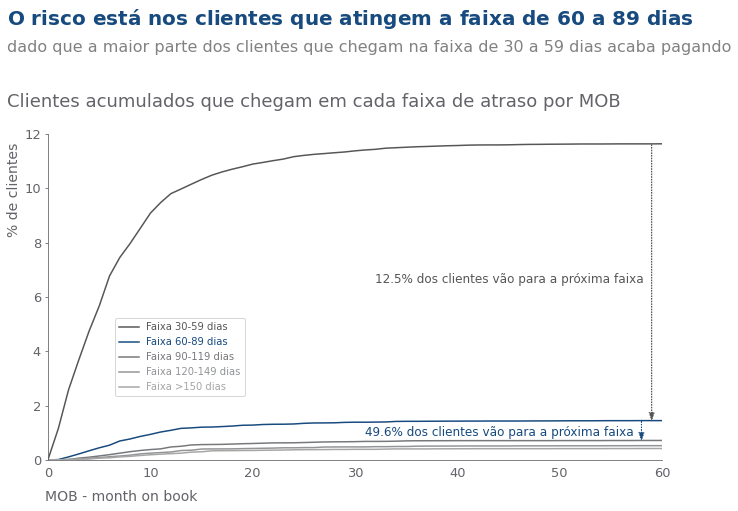

In [224]:
# define colors
grey1, grey2, grey3 = '#231F20', '#414040', '#555655'
grey4, grey5, grey6 = '#646369', '#76787B', '#828282'
grey7, grey8, grey9 = '#929497', '#A6A6A5', '#BFBEBE'
blue1, blue2, blue3, blue4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
red1, red2 = '#C3514E', '#E6BAB7'
green1, green2 = '#0C8040', '#9ABB59'
orange1 = '#F79747'

relacao = taxa_por_faixa.loc[60,'Faixa 60-89 dias']/taxa_por_faixa.loc[60,'Faixa 30-59 dias']
relacao2 = taxa_por_faixa.loc[60,'Faixa 90-119 dias']/taxa_por_faixa.loc[60,'Faixa 60-89 dias']

cores = [grey3,blue1,grey5,grey7,grey8]

ax = taxa_por_faixa.drop('Faixa 1-29 dias', axis=1).plot(figsize=(11, 6), color=cores)
ax.spines['bottom'].set_color(grey4)
ax.spines['left'].set_color(grey4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(bottom=False, color=grey4)
ax.set_xlim([0, 60])
ax.set_ylim([0, 12])
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(13)
    i.set_color(grey4)
ax.text(-4, 16, '$\\bf{O\ risco\ está\ nos\ clientes\ que\ atingem\ a\ faixa\ de\ 60\ a\ 89\ dias}$', fontsize=20, color=blue1)
ax.text(-4, 15, 'dado que a maior parte dos clientes que chegam na faixa de 30 a 59 dias acaba pagando', fontsize=16, color=grey6)
ax.text(-4, 13, 'Clientes acumulados que chegam em cada faixa de atraso por MOB', fontsize=18, color=grey4)
ax.text(-4, 8.3, '% de clientes', fontsize=14, rotation='vertical', color=grey4)
ax.text(-0.3, -1.5, 'MOB - month on book', fontsize=14, color=grey4)
plt.arrow(x=59, y=taxa_por_faixa.loc[58,'Faixa 30-59 dias'], dx=0, 
          dy=taxa_por_faixa.loc[58,'Faixa 60-89 dias']-taxa_por_faixa.loc[58,'Faixa 30-59 dias'],
          color=grey3, ls=':', lw=1, head_width=.5, head_length=.3, length_includes_head=True)
ax.text(32, 6.5, str(round((relacao)*100,1))+'% dos clientes vão para a próxima faixa', fontsize=12, color=grey3)
plt.arrow(x=58, y=taxa_por_faixa.loc[55,'Faixa 60-89 dias'], dx=0, 
          dy=taxa_por_faixa.loc[55,'Faixa 90-119 dias']-taxa_por_faixa.loc[55,'Faixa 60-89 dias'], 
          color=blue1, ls=':', lw=1, head_width=.5, head_length=.3, length_includes_head=True)
ax.text(31, 0.9, str(round((relacao2)*100,1))+'% dos clientes vão para a próxima faixa', fontsize=12, color=blue1)
legenda = plt.legend(bbox_to_anchor=(0.1,0.45))
i = 0
for texto in legenda.get_texts():
  texto.set_color(cores[i])
  i+=1
plt.xlabel('');

In [13]:
primeiro_risco = aprovados.query('Risco == 1')[['MOB','ID_Cliente']].groupby(['ID_Cliente']).min().reset_index()
MOBs_risco = primeiro_risco.merge(MOBs, how="cross", suffixes=('_inicial',''))
MOBs_risco['Risco'] = 0
MOBs_risco.loc[MOBs_risco['MOB'] >= MOBs_risco['MOB_inicial'],'Risco'] = 1
MOBs_risco = MOBs_risco.join(janela, on='ID_Cliente')
MOBs_risco.head()

,ID_Cliente,MOB_inicial,MOB,Risco,Abertura,Fim,Janela
0,5002126,5,0,0,-55,0,55
1,5002126,5,1,0,-55,0,55
2,5002126,5,2,0,-55,0,55
3,5002126,5,3,0,-55,0,55
4,5002126,5,4,0,-55,0,55


In [14]:
vintage = aprovados[['ID_Cliente','Abertura','MOB']].groupby(['Abertura','MOB']).count().reset_index()
vintage = vintage.join(qtd_clientes, on='Abertura')
vintage.drop(['ID_Cliente'], axis=1, inplace=True)
risco = MOBs_risco[['Abertura','MOB','Risco']].groupby(['Abertura','MOB']).sum()
risco.columns=['Qtd_Risco']
vintage = vintage.join(risco, on=['Abertura','MOB'])
vintage['Taxa_Risco'] = vintage['Qtd_Risco']/vintage['Qtd_Clientes']
vintage['Taxa_Risco'].fillna(0, inplace=True)
vintage.Taxa_Risco.max()

0.047325102880658436

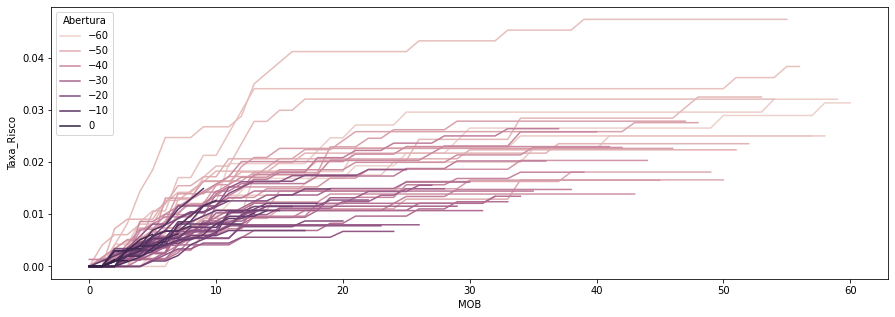

In [15]:
plt.figure(figsize=(15,5))
sns.lineplot(data=vintage, x='MOB', y='Taxa_Risco', hue='Abertura');

In [16]:
cliente_nasceu_risco = list(primeiro_risco.query('MOB == 0')['ID_Cliente'])
cliente_nasceu_risco

[5024071]

In [17]:
aprovados.query('ID_Cliente == @cliente_nasceu_risco').tail()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso,Risco
269193,5024071,-34,pagamento realizado,-38,0,38,4,1,0
269194,5024071,-35,pagamento realizado,-38,0,38,3,1,0
269195,5024071,-36,1-29 dias,-38,0,38,2,2,0
269196,5024071,-37,1-29 dias,-38,0,38,1,2,0
269197,5024071,-38,>150 dias,-38,0,38,0,7,1


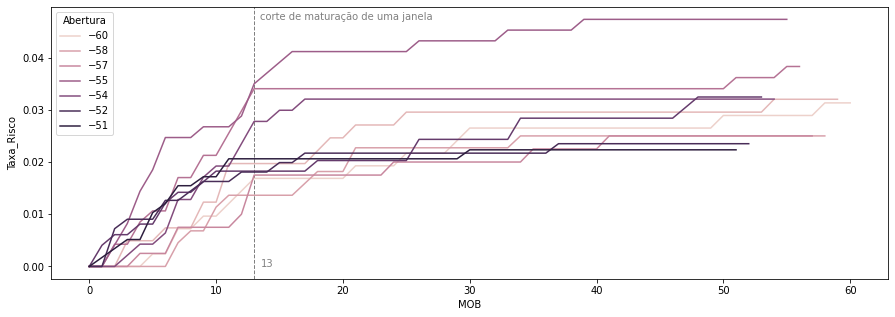

In [18]:
corte = 13
plt.figure(figsize=(15,5))
plt.text(x=corte+.5, y=vintage.Taxa_Risco.max(), s='corte de maturação de uma janela', color='grey')
plt.text(x=corte+.5, y=0, s=str(corte), color='grey')
plt.axvline(x=corte, color='grey', ls='--', lw='1')
sns.lineplot(data=vintage.loc[vintage['Abertura'] < -50], x='MOB', y='Taxa_Risco', hue='Abertura');

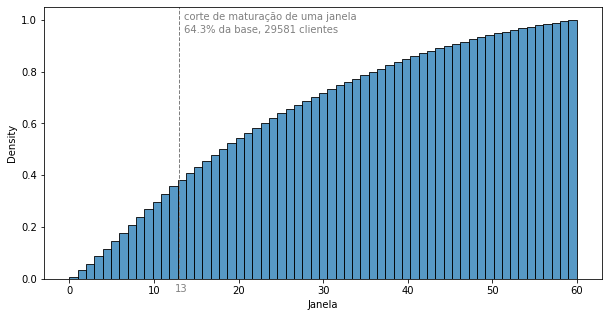

In [19]:
plt.figure(figsize=(10,5))
plt.text(x=corte+.5, y=1, s='corte de maturação de uma janela', color='grey')
plt.text(x=corte-.5, y=-.05, s=str(corte), color='grey')
corte_valor, _ = janela.loc[janela['Janela'] >= corte].shape
texto = str(round((corte_valor/qtd_clientes_total)*100,1))+"% da base, "+str(corte_valor)+" clientes"
plt.text(x=corte+.5, y=0.95, s=texto, color='grey')
plt.axvline(x=corte, color='grey', ls='--', lw='1')
sns.histplot(data=janela, x='Janela', cumulative=True, stat='density', bins=61);

In [20]:
saida = aprovados.loc[aprovados['Janela'] >= corte][['ID_Cliente','Risco']].groupby('ID_Cliente').max()
saida.shape

(29581, 1)

In [21]:
saida.to_csv('target.cvs')